## Hart Algorithm Example

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = (13, 6)

In [3]:
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

## Import Data from HDF file

In [4]:
data = DataSet('/Users/i050650/Documents/DEV/git/smart-meter/nilmtk-tests/generated/smart_meter_all.h5')
print('Loaded', len(data.buildings), 'buildings')

Loaded 1 buildings


## Loading data for Building 1

In [5]:
elec = data.buildings[1].elec

In [6]:
elec.get_timeframe()

TimeFrame(start='2013-03-17 01:01:00+01:00', end='2014-01-01 00:59:00+01:00', empty=False)

## Set a window

In [7]:
#data.set_window(start='2011-04-20',end='2011-04-24')
data.set_window(start='2013-04-01',end='2013-05-30')
elec_1 = data.buildings[1].elec

## Mains and Submeters Data

In [8]:
mains=elec_1.mains()
submeters=elec_1.submeters()

In [9]:
mains.available_ac_types('power')

['active']

In [10]:
submeters.available_ac_types('power')

['active']

## Running HART_85

In [11]:
from nilmtk.legacy.disaggregate.hart_85 import Hart85
h = Hart85()

#### Please set columns accordingly 
#### For REDD, since mains is 'Apparent Power'
#### For IAWE, you may set columns to columns= [('power','active')] or to columns= [('power','active'),('power','reactive')]


## Train the model

In [12]:
h.train(mains, columns=[('power','active')])

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


## Save Model using export_model

In [13]:
#h.export_model('model.pickle')

## Import model after saving

In [14]:
#h.import_model('model.pickle')

In [15]:
output = HDFDataStore('/Users/i050650/Documents/DEV/git/smart-meter/nilmtk-tests/generated/output.h5', 'w')
df = h.disaggregate(mains, output)

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Finding Edges, please wait ...
Edge detection complete.
Cr

In [16]:
# Uncomment it for closing the Output HDFDataStore
#output.close()

In [17]:
df.head()

,0,1,2,3
2013-05-29 18:55:00+02:00,0,0,0,0
2013-05-29 18:56:00+02:00,0,0,0,0
2013-05-29 18:57:00+02:00,0,0,0,0
2013-05-29 18:58:00+02:00,0,0,0,0
2013-05-29 18:59:00+02:00,0,0,0,0


## Returned Disaggregated Dataframe

In [18]:
df.tail()

,0,1,2,3
2013-05-29 23:56:00+02:00,0,603,0,0
2013-05-29 23:57:00+02:00,0,603,0,0
2013-05-29 23:58:00+02:00,153,603,0,0
2013-05-29 23:59:00+02:00,153,603,0,0
2013-05-30 00:00:00+02:00,0,0,0,0


## Since Hart is unsupervised, Find best matched appliances to disaggregated output.

In [19]:
h.best_matched_appliance(submeters, df)

Best Matched Pair is (0, (5, 1, 'SMART_METER'))
Best Matched Pair is (1, (3, 1, 'SMART_METER'))
Best Matched Pair is (2, (5, 1, 'SMART_METER'))
Best Matched Pair is (3, (5, 1, 'SMART_METER'))


## So it shows column 0's appliance (and 1, 3, 4, 5, 6) best matches with washing machine, 2 -> television

In [ ]:
elec  

In [28]:
df_television

physical_quantity,power
type,active
2013-04-01 00:00:00+02:00,67.500000
2013-04-01 00:01:00+02:00,67.300003
2013-04-01 00:02:00+02:00,67.250000
2013-04-01 00:03:00+02:00,66.800003
2013-04-01 00:04:00+02:00,67.000000
...,...
2013-05-29 23:55:00+02:00,7.000000
2013-05-29 23:56:00+02:00,7.000000
2013-05-29 23:57:00+02:00,7.000000


## Comparing for Television

In [27]:
# First we need to take intersection of indices of dataframes of television and predicted (Inner Join)
df_television = next(elec_1['television', 1].load())
merged_df = pd.merge(df[[2]], df_television, left_index = True, right_index = True)

/Users/i050650/anaconda3/envs/nilmtk-env-dev/lib/python3.8/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [38]:
merged_df.head()

,2,"(power, active)"
2013-05-29 18:55:00+02:00,0,7.0
2013-05-29 18:56:00+02:00,0,7.0
2013-05-29 18:57:00+02:00,0,7.0
2013-05-29 18:58:00+02:00,0,7.0
2013-05-29 18:59:00+02:00,0,7.0


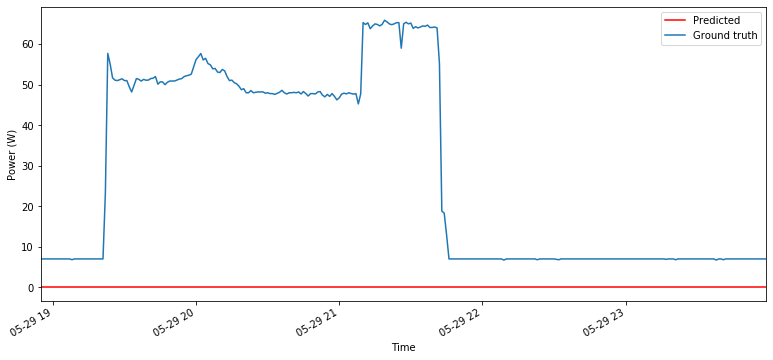

In [43]:
merged_df[2].plot(c='r')
merged_df['power', 'active'].plot()
plt.legend(["Predicted", "Ground truth"]);
plt.ylabel("Power (W)")
plt.xlabel("Time");

## Comparing for Washing Machine

In [20]:
df_washing_machine = next(elec_1['washing machine', 1].load())
merged_df = pd.merge(df[[0]], df_washing_machine, left_index=True, right_index=True)

/Users/i050650/anaconda3/envs/nilmtk-env-dev/lib/python3.8/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
merged_df.head()

,0,"(power, active)"
2013-05-29 18:55:00+02:00,0,18.8571
2013-05-29 18:56:00+02:00,0,0.0000
2013-05-29 18:57:00+02:00,0,0.0000
2013-05-29 18:58:00+02:00,0,0.0000
2013-05-29 18:59:00+02:00,0,0.0000


In [22]:
merged_df.describe()

,0,"(power, active)"
count,305.000000,305.000000
mean,11.537705,0.222482
std,40.466272,3.003018
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,153.000000,49.000000


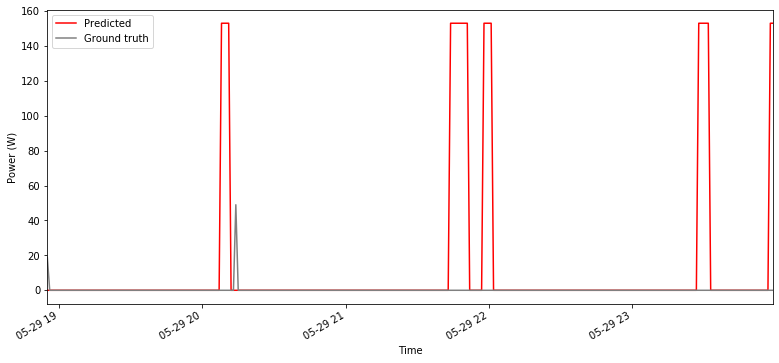

In [23]:
ax1 = merged_df[0].plot(c='r')
ax2 = merged_df['power', 'active'].plot(c='grey')
ax1.legend(["Predicted", "Ground truth"])
plt.ylabel("Power (W)")
plt.xlabel("Time");